In [120]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

import random
from random import sample
import seaborn as sns

from netgraph import Graph

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import itertools

In [4]:
# let's try to use this twitter dataset
# it's in data/congress-twitter
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10493874/

def load_congress_data_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    data = data[0]

    inList = data['inList']
    inWeight = data['inWeight']
    outList = data['outList']
    outWeight = data['outWeight']
    usernameList = data['usernameList']

    return inList, inWeight, outList, outWeight, usernameList

def create_congress_graph(inList, inWeight, outList, outWeight, usernameList):
    G = nx.DiGraph()
    for i, username in enumerate(usernameList):
        G.add_node(i, username=username)
    for i in range(len(inList)):
        for j, in_node in enumerate(inList[i]):
            G.add_edge(in_node, i, weight=inWeight[i][j])
        for j, out_node in enumerate(outList[i]):
            G.add_edge(i, out_node, weight=outWeight[i][j])
    return G

In [5]:
inList, inWeight, outList, outWeight, usernameList = load_congress_data_from_json('data/congress-twitter/congress_network_data.json')
G = create_congress_graph(inList, inWeight, outList, outWeight, usernameList)
print(G)

DiGraph with 475 nodes and 13289 edges


In [6]:
# sanity checks
print(G.number_of_nodes())
print(G.number_of_edges())

# from congress.edgelist,
# should be 0 4 {'weight': 0.002105263157894737}
# and 4 0 {'weight': 0.0036496350364963502}
print(G.nodes[0])
print(G.nodes[4])
print(G.get_edge_data(0, 4))
print(G.get_edge_data(4, 0))

475
13289
{'username': 'SenatorBaldwin'}
{'username': 'SenBlumenthal'}
{'weight': 0.002105263157894737}
{'weight': 0.0036496350364963502}


In [196]:
# try implementing model from the community detection paper
def community_detection(G, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    x0 = np.random.rand(n) # generate random opinions
    print('x0 =', x0) # in the future, let's use political party as initial opinion
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    print('Ni_0 =', Ni)

    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(x[Ni_confidence] - x[i])

        print('x =', x)
        print('computed new opinions')
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            print('x =', x)
            break
        # update rho 
        # rho *= rho
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    return communities_list

In [197]:
# try implementing model from the community detection paper
def community_detection_weighted(G, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    x0 = np.random.rand(n) # generate random opinions
    print('x0 =', x0) # in the future, let's use political party as initial opinion
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    print('Ni_0 =', Ni)

    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))

        print('x =', x)
        print('computed new opinions')
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            print('x =', x)
            break
        # update rho 
        # rho *= rho
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    return communities_list

In [153]:
def to_hex_string(color):
    if color == 'blue':
        return '#2471a3'
    elif color == 'red':
        return '#cb4335'
colors = ['blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'red']
colors = [to_hex_string(color) for color in colors]
colors

['#2471a3',
 '#cb4335',
 '#cb4335',
 '#2471a3',
 '#cb4335',
 '#2471a3',
 '#cb4335',
 '#2471a3',
 '#2471a3',
 '#cb4335']

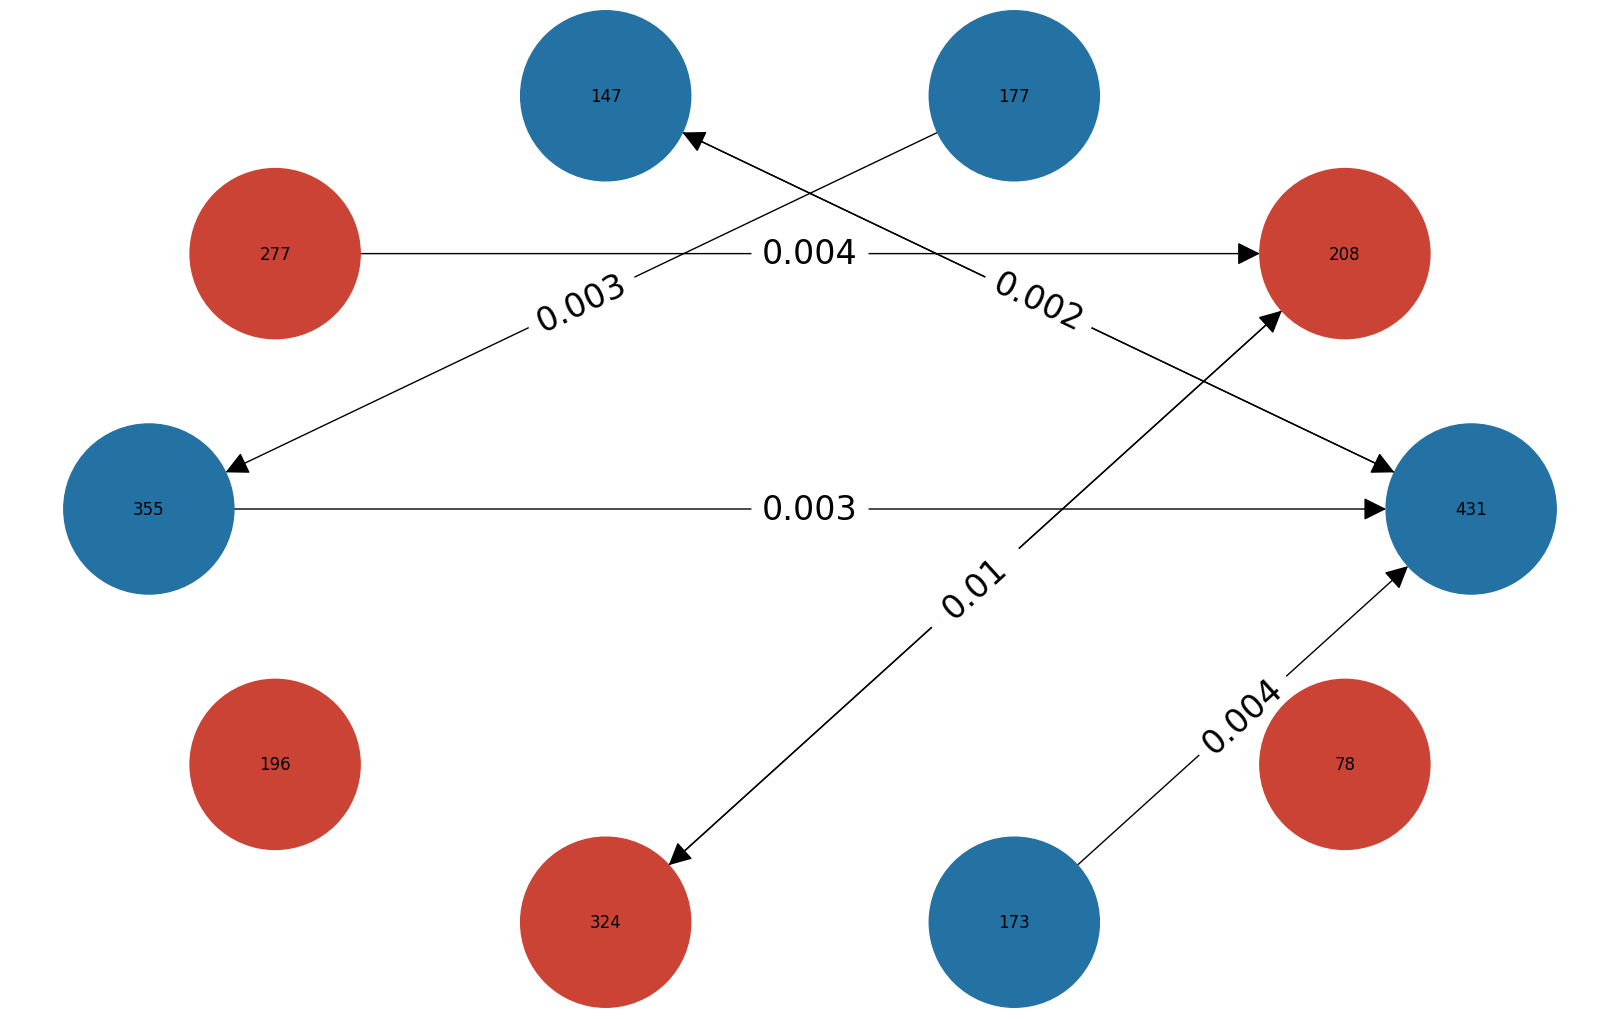

In [165]:
edge_weights = nx.get_edge_attributes(subgraph, 'weight')
rounded_edge_weights = {key: round(value, 3) for key, value in edge_weights.items()}
fig = plt.figure(figsize=(16, 10))
nx.draw_shell(subgraph, node_size=15000, arrowsize=35, node_color=colors, with_labels=True)
nx.draw_networkx_edge_labels(subgraph, pos=nx.shell_layout(subgraph), edge_labels=rounded_edge_weights, font_size=24)
plt.savefig('figs/ex.png')

In [7]:
usernameList
with open('data/parties.json', 'r') as file:
    data = json.load(file)
parties = [item['party'] for item in data]
encoded_parties = [1 if party == 'D' else -1 if party == 'R' else 0 for party in parties]
# sanity check
assert (len([i for i, party in enumerate(encoded_parties) if party == -1]) + len([i for i, party in enumerate(encoded_parties) if party == 1]) + len([i for i, party in enumerate(encoded_parties) if party == 0])) == len(encoded_parties)

def generate_initial_opinions_parties(p):
    x0 = []
    for i in range(len(p)):
        if p[i] == 1:
            x0.append(np.random.uniform(0, 1))
        elif p[i] == -1:
            x0.append(np.random.uniform(-1, 0))
        else:
            x0.append(np.random.uniform(-1, 1))
    return np.array(x0)

In [8]:
# try implementing model from the community detection paper
def community_detection_weighted(G, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    if with_parties:
        x0 = generate_initial_opinions_parties(encoded_parties) # use party opinions
    else:
        x0 = np.random.rand(n) # generate random opinions
    # print('x0 =', x0)
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    # print('starting iterations')
    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))
        # if t % 1000 == 0:
            # print('t =', t)
            # print('x =', x)
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            break
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    # print('communities_list =', communities_list)

    node_to_community = {}
    for i, community in enumerate(communities_list):
        for node in community:
            node_to_community[node] = i
    # print('node_communities =', node_to_community)
    return x, node_to_community

In [9]:
delta_grid = np.linspace(0.01, 0.5, 50)
results = []
for delta in delta_grid:
    xs, node_to_community = community_detection_weighted(G, with_parties=True, delta=delta)
    unique_communities = set(node_to_community.values())
    print('finished delta =', delta, 'with', len(unique_communities), 'unique communities')
    results.append(
        {
            'delta': delta,
            'xs': xs.tolist(),
            'node_to_community': [node_to_community[i] for i in range(len(node_to_community))]
        }
    )

with open('results/delta_grid.json', 'w') as file:
    json.dump(results, file)

converged at t = 20788
finished delta = 0.01 with 5 unique communities
converged at t = 10906
finished delta = 0.02 with 42 unique communities
converged at t = 7322
finished delta = 0.03 with 111 unique communities
converged at t = 5621
finished delta = 0.04 with 162 unique communities
converged at t = 4479
finished delta = 0.05 with 193 unique communities
converged at t = 3705
finished delta = 0.060000000000000005 with 227 unique communities
converged at t = 3204
finished delta = 0.06999999999999999 with 275 unique communities
converged at t = 2827
finished delta = 0.08 with 288 unique communities
converged at t = 2447
finished delta = 0.09 with 317 unique communities
converged at t = 2267
finished delta = 0.09999999999999999 with 332 unique communities
converged at t = 2069
finished delta = 0.11 with 343 unique communities
converged at t = 1905
finished delta = 0.12 with 365 unique communities
converged at t = 1757
finished delta = 0.13 with 351 unique communities
converged at t = 16

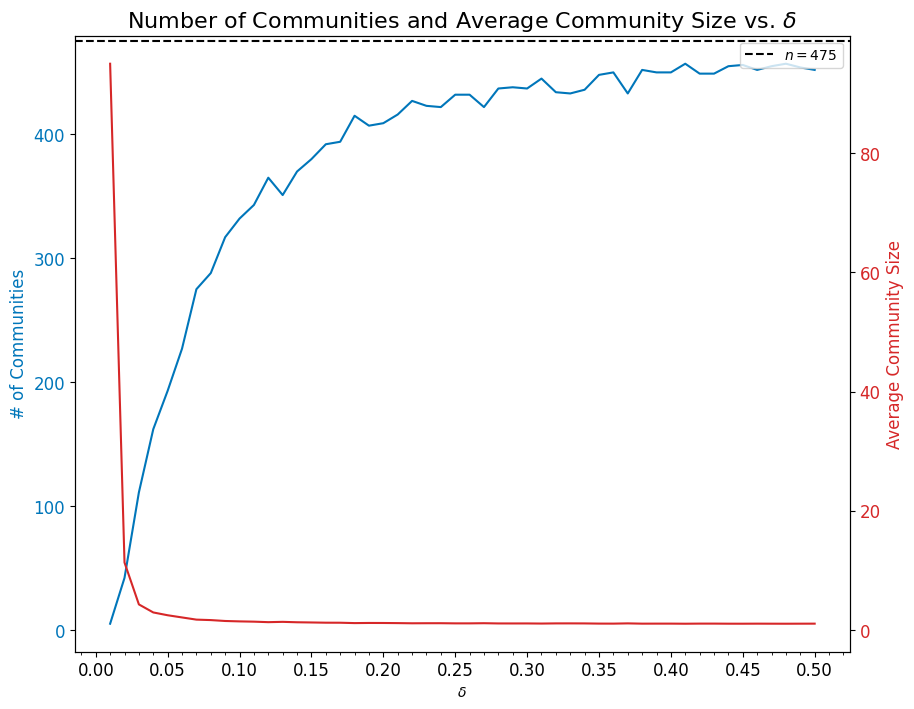

In [110]:
num_communities = []
for result in results:
    num_communities.append(len(set(result['node_to_community'])))

average_community_sizes = []
for result in results:
    community_sizes = [result['node_to_community'].count(i) for i in range(len(set(result['node_to_community'])))]
    average_community_sizes.append(np.mean(community_sizes))

blue = '#0076BA'
red = 'tab:red'

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.xaxis.set_major_locator(MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(MultipleLocator(0.01))
ax1.set_xlabel('$\\delta$')
ax1.set_ylabel('# of Communities', color=blue, fontsize=12)
ax1.plot(delta_grid, num_communities, color=blue)
ax1.tick_params(axis='y', labelcolor='#0076BA', labelsize=12)
ax1.axhline(y=len(results[0]['xs']), color='black', linestyle='--', label='$n=475$')

ax2 = ax1.twinx()

ax2.set_ylabel('Average Community Size', color=red, fontsize=12)
ax2.plot(delta_grid, average_community_sizes, color=red)
ax2.tick_params(axis='y', labelcolor=red, labelsize=12)

ax1.legend(loc='upper right')
ax1.set_title('Number of Communities and Average Community Size vs. $\\delta$', fontsize=16)
plt.savefig('results/figs/delta_grid.png')
plt.show()

In [128]:
def draw_community_graph(G, x, node_to_community):
    if isinstance(node_to_community, dict):
      unique_communities = set(node_to_community.values())
    else:
      unique_communities = set(node_to_community)
    if len(unique_communities) <= 10:
      community_to_color = {
          0: 'tab:blue',
          1: 'tab:red',
          2: 'tab:green',
          3: 'tab:orange',
          4: 'tab:purple',
          5: 'tab:brown',
          6: 'tab:pink',
          7: 'tab:gray',
          8: 'tab:olive',
          9: 'tab:cyan'
      }
      if isinstance(node_to_community, dict):
        node_color = {node: community_to_color[node_to_community[node]] for node in node_to_community.keys()}
    else:
      node_color = None

    Graph(G,
          node_color=node_color, node_edge_width=0, edge_alpha=0.1,
          node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
          edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
          scale=(5, 1)
    )
    fig = plt.gca()
    fig.set_facecolor('white')
    plt.show()

/Users/cjkuk/fall23/cs6850/project/venv/lib/python3.9/site-packages/netgraph/_node_layout.py:1620: UserWarning: There are no connections within community 93. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")
/Users/cjkuk/fall23/cs6850/project/venv/lib/python3.9/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/Users/cjkuk/fall23/cs6850/project/venv/lib/python3.9/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


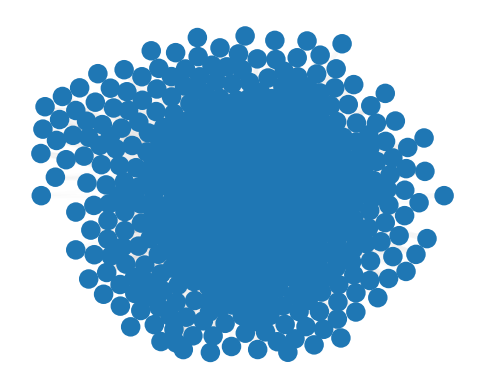

In [453]:
result_ex = results[4]
draw_community_graph(G, result_ex['xs'], result_ex['node_to_community'])

In [33]:
table_indices = [0, 1, 2, 3, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49]
table_results = [results[i] for i in table_indices]

table_node_to_community = [result['node_to_community'] for result in table_results]
table_deltas = [result['delta'] for result in table_results]
table_xs = [result['xs'] for result in table_results]

table_num_communities = [len(set(result['node_to_community'])) for result in table_results]
table_average_community_sizes = [np.mean([result['node_to_community'].count(i) for i in range(len(set(result['node_to_community'])))]) for result in table_results]

opinion_disparities = {}
opinion_disparities_list = []

for param_index, communities in enumerate(table_node_to_community):
    temp_dict = {}
    community_groups = [[i for i, x in enumerate(communities) if x == j] for j in range(max(communities) + 1)]
    for community_index, community_indices in enumerate(community_groups):
        community_opinions = [table_xs[param_index][i] for i in community_indices]
        mean_opinion = sum(community_opinions) / len(community_opinions)
        # if param_index == 0:
        #     print('mean_opinion =', mean_opinion)
        temp_dict[community_index] = mean_opinion

    temp_list = []
    for pair in itertools.combinations(temp_dict.keys(), 2):
        opinion_disparities[(param_index, pair)] = abs(temp_dict[pair[0]] - temp_dict[pair[1]])
        temp_list.append(abs(temp_dict[pair[0]] - temp_dict[pair[1]]))

    opinion_disparities_list.append(temp_list)

mean_opinion_disparities = []
median_opinion_disparities = []
max_opinion_disparities = []
min_opinion_disparities = []
std_opinion_disparities = []
for param_index in range(len(table_results)):
    mean_opinion_disparities.append(np.mean([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    median_opinion_disparities.append(np.median([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    max_opinion_disparities.append(np.max([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    min_opinion_disparities.append(np.min([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    std_opinion_disparities.append(np.std([value for key, value in opinion_disparities.items() if key[0] == param_index]))
print(mean_opinion_disparities)

table = pd.DataFrame({
    '$\\delta$': table_deltas,
    '# of Communities': table_num_communities,
    'Average Community Size': table_average_community_sizes,
    'Opinion Disparities': opinion_disparities_list,
    'Mean Opinion Disparity': mean_opinion_disparities,
    'Median Opinion Disparity': median_opinion_disparities,
    'Max Opinion Disparity': max_opinion_disparities,
    'Min Opinion Disparity': min_opinion_disparities,
    'Std Opinion Disparity': std_opinion_disparities
})
table

[0.6291564406687638, 0.41085624905823226, 0.4931673247595842, 0.5078110100221936, 0.5300350297935715, 0.6027674646495844, 0.6094061942965565, 0.6347146839839276, 0.6495366994293703, 0.632021507140876, 0.6509182132446335, 0.6723750499735918, 0.6646059736467522, 0.6559985479228003]


,$\delta$,# of Communities,Average Community Size,Opinion Disparities,Mean Opinion Disparity,Median Opinion Disparity,Max Opinion Disparity,Min Opinion Disparity,Std Opinion Disparity
0,0.01,5,95.000000,"[1.029568431696605, 1.0302410841016862, 0.0008...",0.629156,1.029905,1.057771,0.000673,0.502536
1,0.02,42,11.309524,"[0.8722162381328193, 0.8719709662501881, 0.871...",0.410856,0.214019,1.063217,0.000103,0.395939
2,0.03,111,4.279279,"[0.9910766413753045, 0.001191945723506449, 0.0...",0.493167,0.183226,1.336724,0.000111,0.472006
3,0.04,162,2.932099,"[0.008059424133749216, 0.9748668621301235, 0.0...",0.507811,0.362958,1.544877,0.000104,0.418106
4,0.05,193,2.461140,"[0.04801224702810203, 0.003701861875512913, 0....",0.530035,0.409698,1.637799,0.000088,0.428059
5,0.10,332,1.430723,"[0.07019142611474372, 1.1440372257293623, 0.17...",0.602767,0.524330,1.857756,0.000101,0.436232
6,0.15,380,1.250000,"[1.3204912493972818, 1.210103704613097, 0.8972...",0.609406,0.527177,1.857101,0.000102,0.438697
7,0.20,409,1.161369,"[0.32044780253733307, 0.736759524461623, 0.613...",0.634715,0.561536,1.847868,0.000104,0.451643
8,0.25,432,1.099537,"[0.051979637654735567, 1.4863760181449486, 0.0...",0.649537,0.569764,1.908178,0.000101,0.462112
9,0.30,437,1.086957,"[0.9880931670059672, 0.28171289534498023, 0.75...",0.632022,0.551662,1.899155,0.000103,0.449096


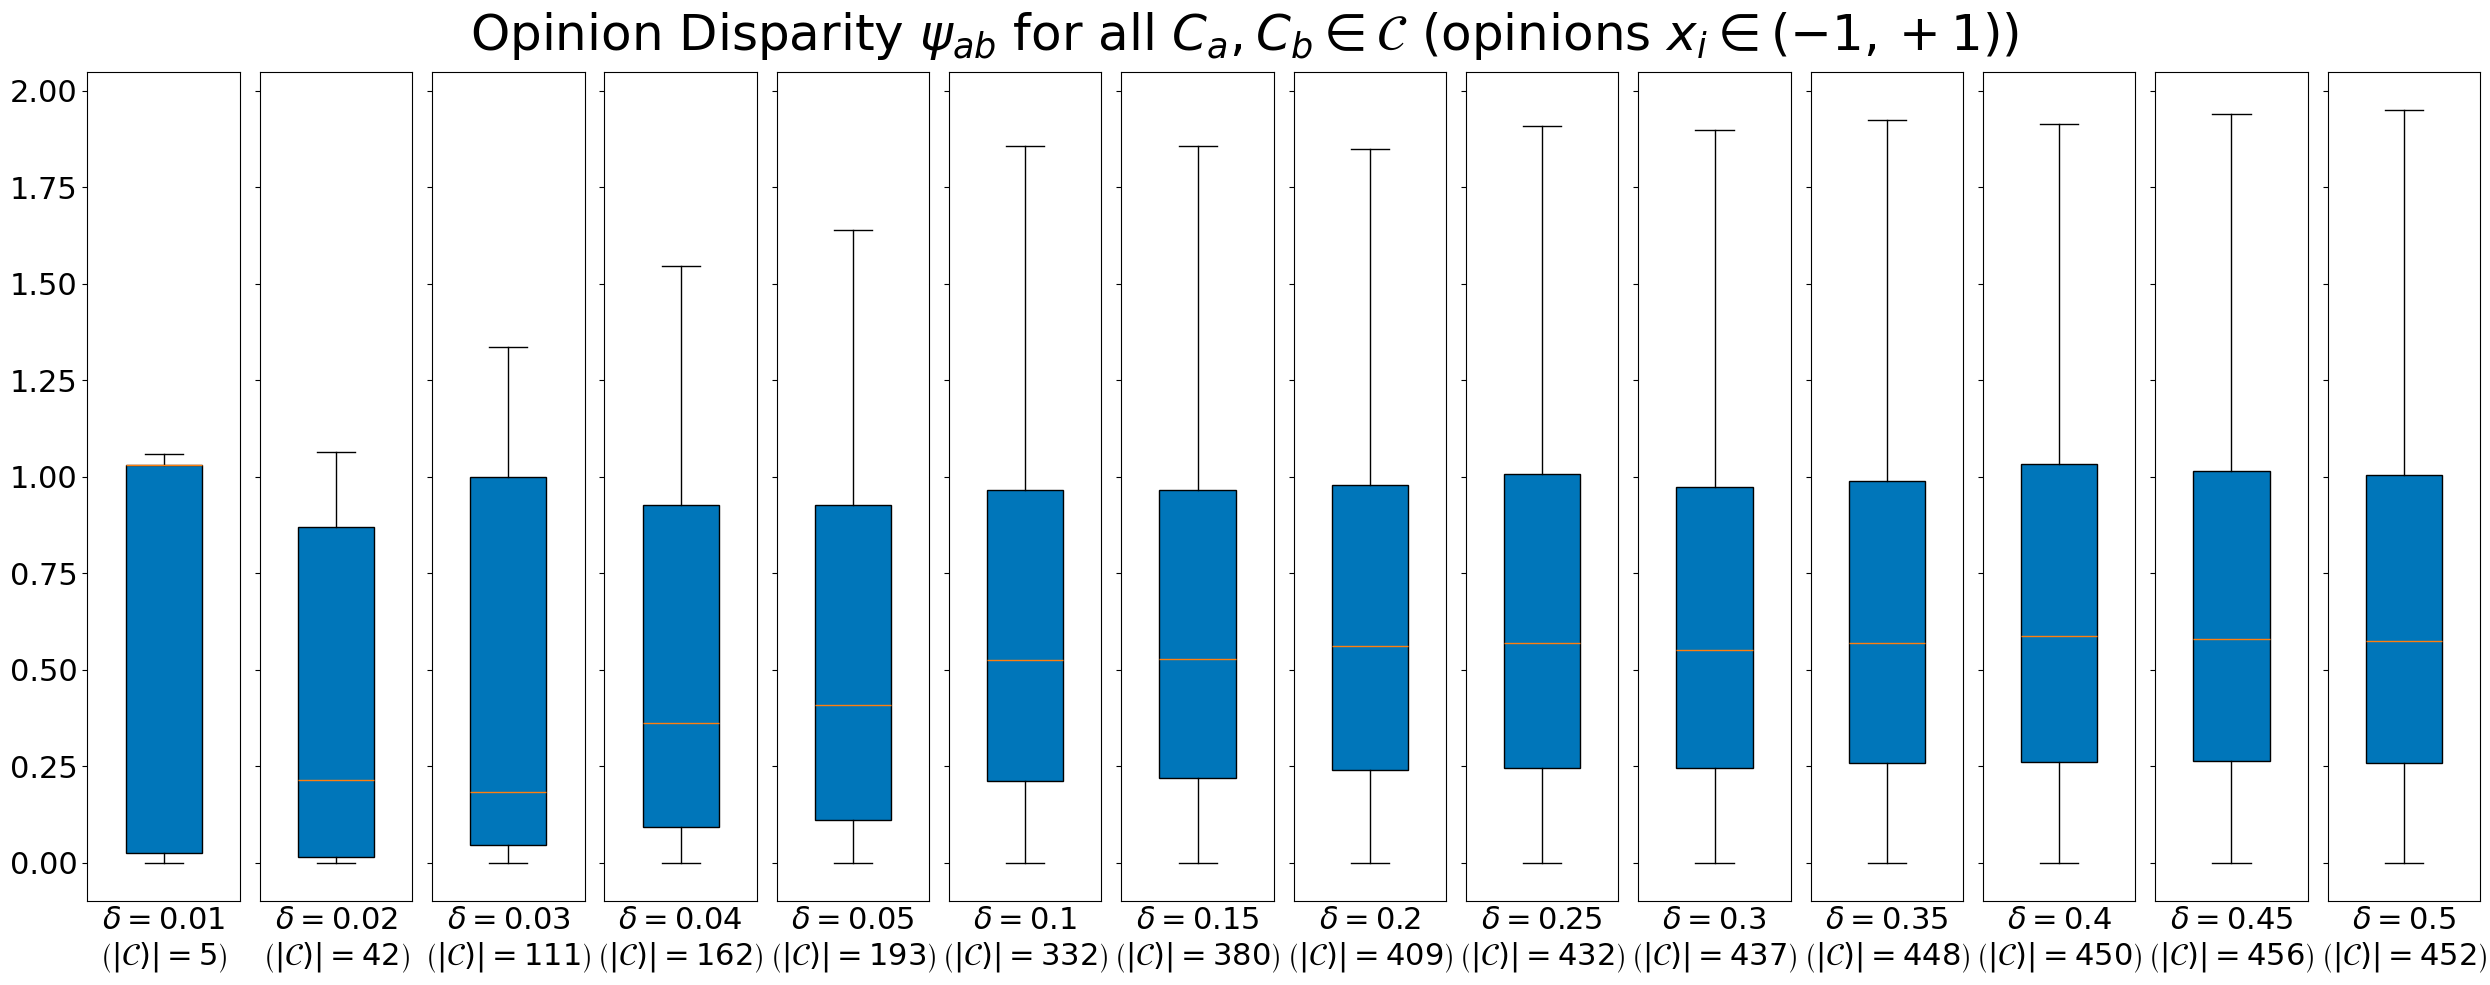

In [115]:
fig, ax = plt.subplots(1, len(opinion_disparities), sharey=True, tight_layout=True, figsize=(25, 10))
for i, disparities in enumerate(opinion_disparities):
    bp = ax[i].boxplot(disparities, vert=True, widths=0.5, patch_artist=True)
    for box in bp['boxes']:
        box.set(facecolor='#0076BA')  # Set the color of the box fill
    ax[i].set_xticks([])
    ax[i].set_xlabel('$\\delta = ' + str(round(table_deltas[i], 2)) + '$\n' + '$\\left(|\\mathcal{C})|= ' + str(table_num_communities[i]) + '\\right)$', fontsize=22)
    ax[i].tick_params(axis='y', labelsize=22)

fig.suptitle('Opinion Disparity $\\psi_{ab}$ for all $C_a, C_b\in\mathcal{C}$ (opinions $x_i\in (-1,+1)$)', fontsize=36)

plt.savefig('results/figs/opinion_disparities_boxplot.png')
plt.show()

In [135]:
subgraph = G.subgraph(random.sample(list(G.nodes()), 100))
sampled_results = results[0]
print(subgraph)
draw_community_graph(subgraph, sampled_results['xs'], sampled_results['node_to_community'])
num_communities = len(set(node_to_community.values()))
num_communities

DiGraph with 100 nodes and 563 edges


AttributeError: 'list' object has no attribute 'keys'